In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
import umap.plot
import random

In [2]:
# Define the path to your dataset folder
dataset_folder = 'data/'

# Define image dimensions
image_width, image_height = 224, 224

# Define the class labels
class_labels = ['UPJ_obstruction', 'Normal']

# Define image transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((image_width, image_height)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
# Collect all image paths and labels
image_paths = []
labels = []
for label in class_labels:
    class_folder = os.path.join(dataset_folder, label)
    class_index = class_labels.index(label)
    for img in os.listdir(class_folder):
        image_paths.append(os.path.join(class_folder, img))
        labels.append(class_index)

In [5]:
# Split data into training and testing sets
X_train_paths, X_test_paths, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

In [6]:
# Create datasets
train_dataset = CustomDataset(X_train_paths, y_train, transform=transform)
test_dataset = CustomDataset(X_test_paths, y_test, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
# Choose the base model (ConvNeXt)
base_model_name = 'ConvNeXt'  # Change this to 'ConvNeXt' to use ConvNeXt

# Load the pre-trained ConvNeXt model
if base_model_name == 'ConvNeXt':
    base_model = models.convnext_tiny(pretrained=True)
    num_filters = 768
else:
    raise ValueError("Invalid base model name. Choose 'ConvNeXt'.")

C:\Users\Akshat\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Akshat\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to C:\Users\Akshat/.cache\torch\hub\checkpoints\convnext_tiny-983f1562.pth
100%|███████████████████████████████████████████████████████████████████████████████| 109M/109M [00:07<00:00, 15.1MB/s]


In [8]:
# Freeze the weights of the base model
for param in base_model.parameters():
    param.requires_grad = False

In [9]:
# Define the custom model for ConvNeXt
class CustomModel(nn.Module):
    def __init__(self, base_model, num_filters, num_classes):
        super(CustomModel, self).__init__()
        self.base_model = base_model
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(num_filters, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = CustomModel(base_model, num_filters, len(class_labels))

In [10]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CustomModel(
  (base_model): ConvNeXt(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=96, out_features=384, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=384, out_features=96, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((9

In [11]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

In [13]:
# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10, Loss: 0.5731, Accuracy: 72.79%
Epoch 2/10, Loss: 0.3535, Accuracy: 91.54%
Epoch 3/10, Loss: 0.2600, Accuracy: 92.28%
Epoch 4/10, Loss: 0.2247, Accuracy: 93.75%
Epoch 5/10, Loss: 0.2078, Accuracy: 94.12%
Epoch 6/10, Loss: 0.1943, Accuracy: 94.12%
Epoch 7/10, Loss: 0.2003, Accuracy: 94.12%
Epoch 8/10, Loss: 0.2221, Accuracy: 93.38%
Epoch 9/10, Loss: 0.1818, Accuracy: 94.12%
Epoch 10/10, Loss: 0.1807, Accuracy: 93.38%


In [14]:
# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, F1-score: {f1:.2f}')
    return all_labels, all_predictions

In [15]:
# Evaluate the model
all_labels, all_predictions = evaluate_model(model, test_loader, criterion)

Test Loss: 0.5397, Test Accuracy: 92.65%, F1-score: 0.93


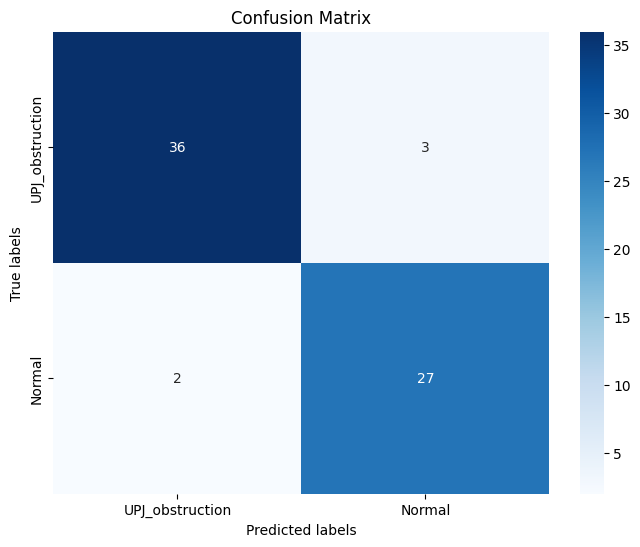

In [16]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

C:\Users\Akshat\myenv\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


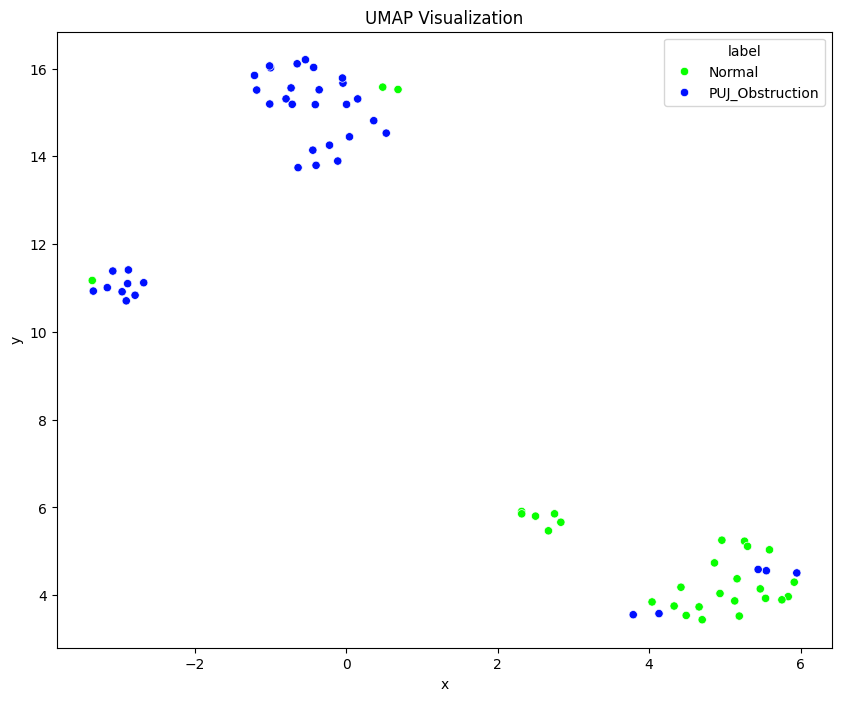

In [17]:
# Extract features for UMAP visualization
model.eval()
features = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model.base_model(inputs)
        outputs = outputs.view(outputs.size(0), -1)  # Flatten the outputs
        features.append(outputs.cpu().numpy())
features = np.concatenate(features, axis=0)

# Apply UMAP to visualize the feature embeddings
umap_model = umap.UMAP(n_components=2, random_state=42)
X_test_embedded = umap_model.fit_transform(features)

# Define a mapping dictionary for class labels
label_mapping = {0: 'PUJ_Obstruction', 1: 'Normal'}

# Map numerical labels to string representations
label_strings = [label_mapping[label] for label in y_test]

# Create DataFrame with string labels
df = pd.DataFrame({'x': X_test_embedded[:, 0], 'y': X_test_embedded[:, 1], 'label': label_strings})

# Plot UMAP visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(x='x', y='y', hue='label', palette=sns.color_palette('hsv', len(class_labels)), data=df, legend='full')
plt.title('UMAP Visualization')
plt.show()

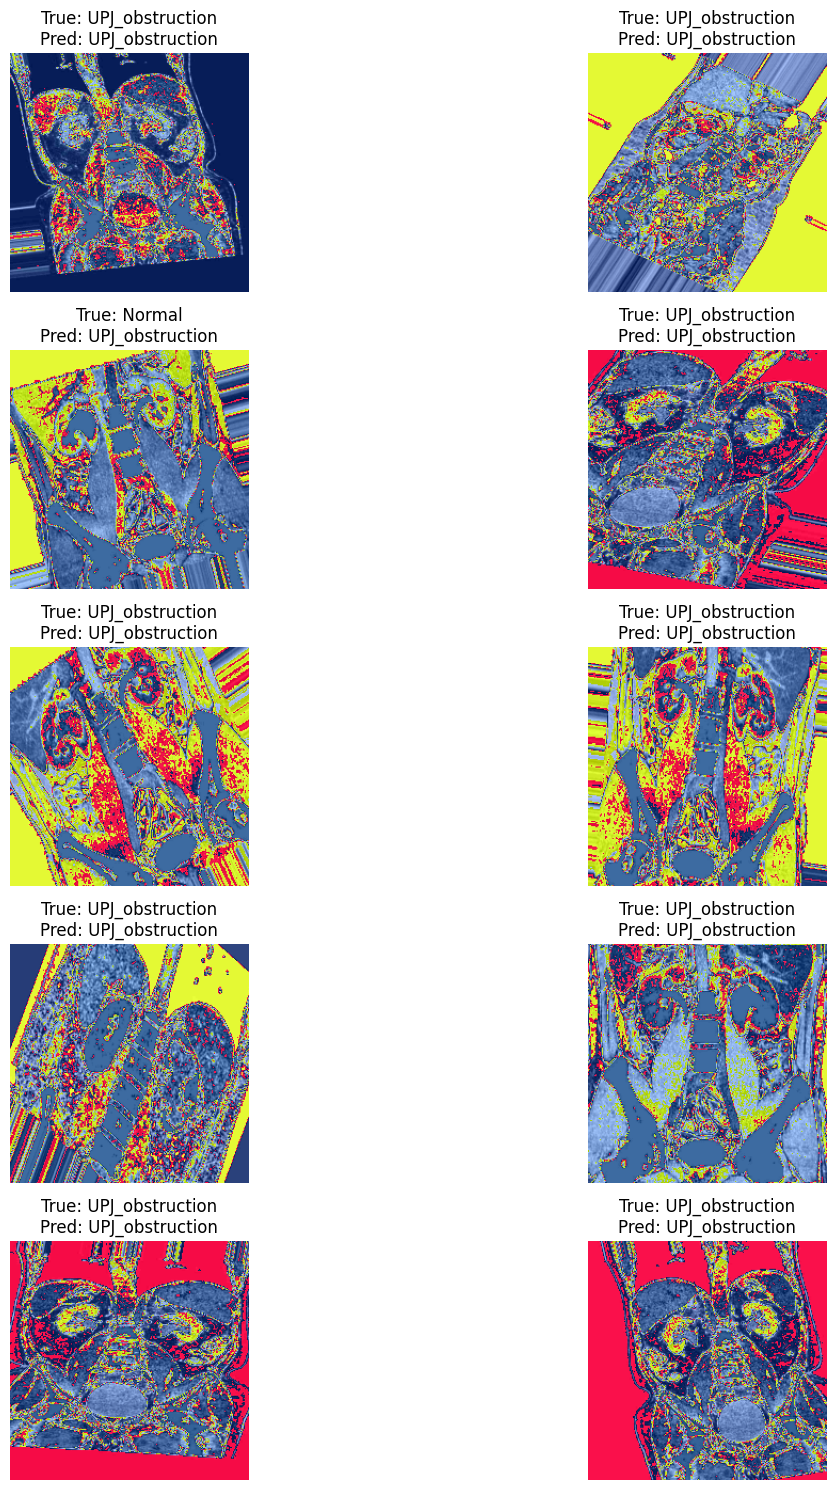

In [18]:
def show_predictions(model, test_dataset, class_labels, num_images=10):
    # Set the model to evaluation mode
    model.eval()
    
    # Randomly select images from the test set
    indices = random.sample(range(len(test_dataset)), num_images)
    
    # Prepare the figure
    plt.figure(figsize=(15, 15))
    
    for i, idx in enumerate(indices):
        image, true_label = test_dataset[idx]
        image = image.to(device).unsqueeze(0)
        
        with torch.no_grad():
            output = model(image)
            _, predicted_label = torch.max(output, 1)
        
        true_label = class_labels[true_label]
        predicted_label = class_labels[predicted_label.item()]
        
        # Convert the image tensor to numpy for display
        image = image.squeeze().cpu().numpy().transpose((1, 2, 0))
        image = (image * 255).astype(np.uint8)
        
        # Display the image with true and predicted labels
        plt.subplot(num_images // 2, 2, i + 1)
        plt.imshow(image)
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function to display images and their predictions
show_predictions(model, test_dataset, class_labels, num_images=10)